In [1]:
import numpy as np
import pandas as pd
import ncafm.io as io
import ncafm.functions as fcn
from pathlib import Path

import matplotlib.pyplot as plt

## Test loading the data

In [2]:
additional_path = 'ncafm/example_data'
filename = 'all_data_dataframe_237K.csv'

path = io.get_example_data_file_path(filename, data_dir = additional_path)

z_df_dataframe = io.load_data(path)


In [16]:
z_df_dataframe

,z,-0.0,0.75,2.0,4.0,6.0,8.0,10.0
0,-3.182825e-08,51.750179,51.581310,51.130814,49.505810,46.584351,41.749966,33.953133
1,-3.162825e-08,43.953426,43.928509,43.816441,42.090847,39.372910,34.885902,27.489771
2,-3.142825e-08,36.527794,36.373009,36.233540,34.562767,31.635241,27.508020,20.527580
3,-3.122825e-08,28.104694,28.243338,28.223377,26.402557,23.151896,18.147322,11.085422
4,-3.102825e-08,19.526001,19.727394,19.668325,17.515757,13.588511,7.788128,-0.174825
...,...,...,...,...,...,...,...,...
108,-1.022831e-08,-0.629711,-0.526609,-0.487231,-1.042318,-2.116411,-3.999531,-6.450719
109,-1.002831e-08,-0.676826,-0.554232,-0.562571,-0.982578,-2.094154,-4.020424,-6.403704
110,-9.828311e-09,-0.634787,-0.559015,-0.483544,-1.015127,-2.147274,-3.872620,-6.350922
111,-9.628311e-09,-0.721081,-0.548445,-0.548138,-1.033069,-2.181116,-3.927863,-6.343535


In [4]:
#define experimental parameters

#amplitude, set to 0.5 nm
a = 0.5*10**-9

#spring constant, 1800 N/m
k = 1800

#central frequency Hz
f_0 = 19796.5

### Dumnmy data

In [5]:
dummy_a = 1*10**-9
dummy_k = 2000 
dummy_f0 = 20*10**3
dummy_z = np.arange(1, 21, 0.5)*10**-9

const1 = 10**-7
const2 = 1.1*10**-9

dummy_df = const1*((const2)**2/dummy_z**3 - (const2)**1/dummy_z**2)

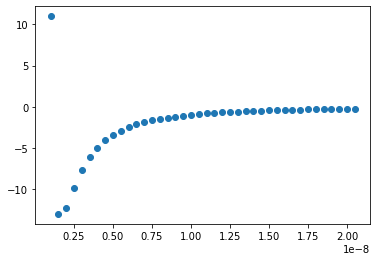

In [6]:
plt.scatter(dummy_z, dummy_df)

In [13]:
fcn.df2force(dummy_z, dummy_df, dummy_a, dummy_k, dummy_f0)

array([ 2.34538854e-09, -5.37371270e-09, -9.27771448e-09, -8.10569783e-09,
       -6.74863638e-09, -5.64878420e-09, -4.79066963e-09, -4.11565349e-09,
       -3.57531728e-09, -3.13483791e-09, -2.76968791e-09, -2.46244975e-09,
       -2.20054724e-09, -1.97472910e-09, -1.77806415e-09, -1.60526964e-09,
       -1.45225516e-09, -1.31580770e-09, -1.19337020e-09, -1.08288335e-09,
       -9.82670559e-10, -8.91353297e-10, -8.07787716e-10, -7.31016712e-10,
       -6.60233167e-10, -5.94751463e-10, -5.33985146e-10, -4.77429225e-10,
       -4.24645980e-10, -3.75253415e-10, -3.28915701e-10, -2.85335035e-10,
       -2.44244366e-10, -2.05400341e-10, -1.68575378e-10, -1.33546576e-10,
       -1.00075063e-10, -6.78519661e-11, -3.62234412e-11])

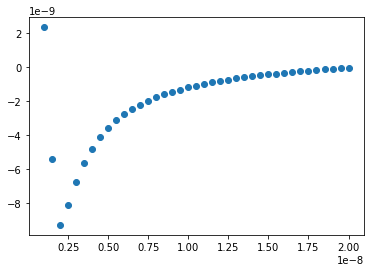

In [15]:
plt.scatter(dummy_z[:-1], fcn.df2force(dummy_z, dummy_df, dummy_a, dummy_k, dummy_f0))

### Real data

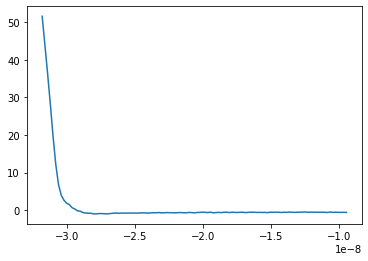

In [17]:
plt.plot(z_df_dataframe['z'], z_df_dataframe['0.75'])

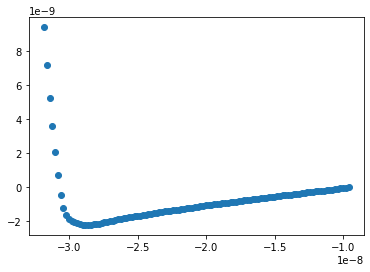

In [18]:
plt.scatter(z_df_dataframe['z'][:-1], fcn.df2force(z_df_dataframe['z'], z_df_dataframe['0.75'], a, k, f_0))